In [1]:
import psycopg2
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

/usr/local/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
conn = psycopg2.connect("dbname=football")
cur = conn.cursor()

sql = """
WITH markets AS (
    SELECT
        event_name,
        event_id,
        open_date,
        mc_id
    FROM
        market_changes
    GROUP BY
        event_name,
        event_id,
        open_date,
        mc_id
)

SELECT
mc.event_name,
mc.event_id,
mc.open_date,
min(r.name) AS score_name
FROM
runners r
INNER JOIN
markets mc
ON mc.mc_id = r.mc_id
WHERE r.status = 'WINNER'
GROUP BY
mc.event_name,
mc.event_id,
mc.open_date
ORDER BY
mc.event_id
"""

cur.execute(sql)

results = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
conn.close()

In [3]:
df = pd.DataFrame(results, columns=colnames)
df.head()

,event_name,event_id,open_date,score_name
0,T v A,27041861,2013-07-29 10:14:25,0 - 0
1,New v Cat 5,27041907,2013-07-29 11:44:42,1 - 0
2,Test v Subject,27144881,2015-12-14 12:34:00,1 - 0
3,Test v Subject,27144881,2020-02-06 11:30:00,1 - 0
4,Tottenham v Man City,27425811,2015-05-03 15:00:00,0 - 1


In [4]:
df.shape

(25036, 4)

### Creating results

In [5]:
df.loc[:, 'home_team'] = df.event_name.apply(lambda x: x.split(' v ')[0])
df.loc[:, 'away_team'] = df.event_name.apply(lambda x: x.split(' v ')[-1])
df = df[(df.open_date >= '2015-04-01') & (df.open_date < '2019-01-01')].sort_values(by='open_date')
df.head()

,event_name,event_id,open_date,score_name,home_team,away_team
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea
93,Nostell Miners Welfare v Frickley Athletic,27434210,2015-05-01 18:30:00,Any Other Away Win,Nostell Miners Welfare,Frickley Athletic
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham


## ELO

In [6]:
HISTORY = 10
k_factor = 32
elo_width = 400.

def calculate_new_elos(rating_a, rating_b, score_a, k_factor, elo_width):
    """Calculates and returns the new Elo ratings for two players.
    score_a is 1 for a win by player A, 0 for a loss by player A, or 0.5 for a draw.
    """

    e_a = expected_result(rating_a, rating_b, elo_width)
    e_b = 1. - e_a
    new_rating_a = rating_a + k_factor * (score_a - e_a)
    score_b = 1. - score_a
    new_rating_b = rating_b + k_factor * (score_b - e_b)
    return new_rating_a, new_rating_b
    

def expected_result(elo_a, elo_b, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a


def update_end_of_season(elos):
    """Regression towards the mean
    
    Following 538 nfl methods
    https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/
    """
    diff_from_mean = elos - np.mean(elos)
    elos -= diff_from_mean/3
    return elos

In [7]:
def create_team_frame(frame, elo=1000):
    teams = pd.DataFrame(pd.unique(frame[['home_team', 'away_team']].values.ravel('K')), columns=['team'])   
    teams.loc[:, 'elo']  = elo
    return teams

def calculate_numeric_result(entry):
    home_goal = int(entry.split(' - ')[0])
    away_goal = int(entry.split(' - ')[1])
    if home_goal > away_goal:
        return 1
    elif home_goal == away_goal:
        return 0.5
    else:
        return 0

def calculate_result(row):
    result = row.score_name
    if result == 'Any Other Home Win':
        return 1
    elif result == 'Any Other Away Win':
        return 0
    elif result == 'Any Other Draw':
        return 0.5
    elif result == 'Any unquoted':
        return 0.5
    else:
        return calculate_numeric_result(result)
     

In [8]:
df.loc[:, 'home_elo'] = 1000.
df.loc[:, 'away_elo'] = 1000.
df.loc[:, 'other_home_elo'] = 1000.
df.loc[:, 'other_away_elo'] = 1000.
df.loc[:, 'final_home_elo'] = 1000.
df.loc[:, 'final_away_elo'] = 1000.
season_frame = create_team_frame(df)
other_season_frame = create_team_frame(df)
final_season_frame = create_team_frame(df)
for index, row in df.iterrows():
    home = row.home_team
    away = row.away_team
    home_elo = season_frame[season_frame.team == home].elo.values[0]
    away_elo = season_frame[season_frame.team == away].elo.values[0]
    other_home_elo = other_season_frame[other_season_frame.team == home].elo.values[0]
    other_away_elo = other_season_frame[other_season_frame.team == away].elo.values[0]
    final_home_elo = final_season_frame[final_season_frame.team == home].elo.values[0]
    final_away_elo = final_season_frame[final_season_frame.team == away].elo.values[0]        
    df.loc[df.event_id == row.event_id, 'home_elo'] = home_elo
    df.loc[df.event_id == row.event_id, 'away_elo'] = away_elo
    df.loc[df.event_id == row.event_id, 'other_home_elo'] = other_home_elo
    df.loc[df.event_id == row.event_id, 'other_away_elo'] = other_away_elo    
    df.loc[df.event_id == row.event_id, 'final_home_elo'] = final_home_elo
    df.loc[df.event_id == row.event_id, 'final_away_elo'] = final_away_elo        
    expected_results = expected_result(home_elo, away_elo, elo_width)
    other_expected_results = expected_result(other_home_elo, other_away_elo, elo_width + 400)
    final_expected_results = expected_result(final_home_elo, final_away_elo, elo_width - 200)    
    result = calculate_result(row)
    new_home_elo, new_away_elo = calculate_new_elos(home_elo, away_elo, result, k_factor, elo_width)
    other_new_home_elo, other_new_away_elo = calculate_new_elos(other_home_elo, other_away_elo, result, k_factor, elo_width+400)
    final_new_home_elo, final_new_away_elo = calculate_new_elos(final_home_elo, final_away_elo, result, k_factor, elo_width-200)    
    season_frame.loc[season_frame.team == home, 'elo'] = new_home_elo
    season_frame.loc[season_frame.team == away, 'elo'] = new_away_elo
    other_season_frame.loc[other_season_frame.team == home, 'elo'] = other_new_home_elo
    other_season_frame.loc[other_season_frame.team == away, 'elo'] = other_new_away_elo
    final_season_frame.loc[final_season_frame.team == home, 'elo'] = final_new_home_elo
    final_season_frame.loc[final_season_frame.team == away, 'elo'] = final_new_away_elo

In [9]:
df[['event_name', 'event_id', 'open_date']].drop_duplicates().shape

(25031, 3)

In [10]:
df.sort_values(by='home_elo').head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,final_home_elo,final_away_elo
19268,North Ferriby Utd v Boston Utd,28543909,2018-01-20 15:00:00,Any Other Away Win,North Ferriby Utd,Boston Utd,741.818654,985.533270,632.304319,941.752660,838.095384,1022.722135
19923,North Ferriby Utd v Southport,28581212,2018-02-17 15:00:00,0 - 3,North Ferriby Utd,Southport,743.758148,939.237792,624.198659,849.141333,845.699981,994.844908
19566,North Ferriby Utd v Leamington,28560969,2018-02-03 15:00:00,1 - 1,North Ferriby Utd,Leamington,746.933582,990.294107,632.420550,1012.879264,847.238494,980.434835
20158,Cowdenbeath v Peterhead,28591974,2018-02-24 15:00:00,0 - 2,Cowdenbeath,Peterhead,751.852184,1016.885075,650.575336,1041.298908,836.438821,996.294351
20574,Cowdenbeath v Elgin,28624513,2018-03-17 15:00:00,3 - 1,Cowdenbeath,Elgin,752.345995,939.729064,646.630615,939.229032,841.791866,959.075136


In [11]:
df.sort_values(by='home_elo', ascending=False).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,final_home_elo,final_away_elo
22228,Man City v Huddersfield,28824829,2018-08-19 12:30:00,6 - 1,Man City,Huddersfield,1410.163957,1069.134611,1609.884822,1057.571518,1258.088813,1071.602128
15014,Celtic v Lyon,28306512,2017-07-15 14:00:00,Any Other Away Win,Celtic,Lyon,1409.009169,971.443550,1593.766378,969.785864,1266.884093,974.338501
23248,Man City v Lyon,28880548,2018-09-19 19:00:00,1 - 2,Man City,Lyon,1407.409590,1026.732961,1612.570805,1018.297121,1251.384851,1034.386958
22887,Man City v Newcastle,28854367,2018-09-01 16:30:00,2 - 1,Man City,Newcastle,1403.098891,1079.993199,1606.347055,1112.613022,1248.482610,1048.257397
24651,Man City v Shakhtar,28974151,2018-11-07 20:00:00,6 - 0,Man City,Shakhtar,1401.287688,995.202096,1618.825038,992.762581,1239.099085,997.009903


In [17]:
df.loc[:, 'home_team_goal'] = df.score_name.apply(lambda x: int(x.split(' - ')[0]) if len(x.split(' - ')) > 1 else None)
df.loc[:, 'away_team_goal'] = df.score_name.apply(lambda x: int(x.split(' - ')[1]) if len(x.split(' - ')) > 1 else None)
df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,final_home_elo,final_away_elo,home_team_goal,away_team_goal
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1.0,3.0
93,Nostell Miners Welfare v Frickley Athletic,27434210,2015-05-01 18:30:00,Any Other Away Win,Nostell Miners Welfare,Frickley Athletic,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,NaN,NaN
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,5.0,0.0
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1.0,2.0
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,4.0,2.0


In [18]:
HOME_TEAM_BASE = np.mean(df.home_team_goal)
AWAY_TEAM_BASE = np.mean(df.away_team_goal)

k_factor = 32
score_k_factor = 0.05

def calculate_new_elos_score(rating_a, rating_b, score_a, home, k_factor):
    """Calculates and returns the new Elo ratings for two players.
    score_a is 1 for a win by player A, 0 for a loss by player A, or 0.5 for a draw.
    """
    if home:
        e_a = expected_result_score(rating_a, rating_b, HOME_TEAM_BASE)
    else:
        e_a = expected_result_score(rating_a, rating_b, AWAY_TEAM_BASE)
    new_rating_a = rating_a + (k_factor * (score_a - e_a))
    new_rating_b = rating_b + (k_factor * (score_a - e_a))
    return new_rating_a, new_rating_b
    

def expected_result_score(elo_a, elo_b, base):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = (elo_a/base) * (elo_b/base) * base
    return expect_a


def update_end_of_season(elos):
    """Regression towards the mean
    
    Following 538 nfl methods
    https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/
    """
    diff_from_mean = elos - np.mean(elos)
    elos -= diff_from_mean/3
    return elos

In [19]:
def get_elos(frame, names):
    return [frame[frame.team == entry].elo.values[0] for entry in names]

#df.loc[:, 'home_elo'] = 1000.
#df.loc[:, 'away_elo'] = 1000.
df.loc[:, 'home_attack_elo'] = HOME_TEAM_BASE
df.loc[:, 'home_defence_elo'] = AWAY_TEAM_BASE
df.loc[:, 'away_attack_elo'] = AWAY_TEAM_BASE
df.loc[:, 'away_defence_elo'] = HOME_TEAM_BASE


#season_frame = create_team_frame(df)
home_attack_frame = create_team_frame(df, HOME_TEAM_BASE)
home_defence_frame = create_team_frame(df, AWAY_TEAM_BASE)
away_attack_frame = create_team_frame(df, AWAY_TEAM_BASE)
away_defence_frame = create_team_frame(df, HOME_TEAM_BASE)

i = 0

for index, row in df.iterrows():
    if i % 1000 == 0:
        print(i)
    i += 1
    home = row.home_team
    away = row.away_team
    home_team_goals = row.home_team_goal
    away_team_goals = row.away_team_goal
    
#    home_elo, away_elo = get_elos(season_frame, (home, away))
    home_attack_elo = get_elos(home_attack_frame, (home,))[0]
    home_defence_elo = get_elos(home_defence_frame, (home,))[0]
    away_attack_elo = get_elos(away_attack_frame, (away,))[0]
    away_defence_elo = get_elos(away_defence_frame, (away,))[0]
        
#    df.loc[df.event_id == row.event_id, 'home_elo'] = home_elo
#    df.loc[df.event_id == row.event_id, 'away_elo'] = away_elo
    df.loc[df.event_id == row.event_id, 'home_attack_elo'] = home_attack_elo
    df.loc[df.event_id == row.event_id, 'away_attack_elo'] = away_attack_elo
    df.loc[df.event_id == row.event_id, 'home_defence_elo'] = home_defence_elo
    df.loc[df.event_id == row.event_id, 'away_defence_elo'] = away_defence_elo  
        
    expected_results = expected_result(home_elo, away_elo, elo_width)
    result = calculate_result(row)
#    new_home_elo, new_away_elo = calculate_new_elos(home_elo, away_elo, result, k_factor, elo_width)
#    season_frame.loc[season_frame.team == home, 'elo'] = new_home_elo
#    season_frame.loc[season_frame.team == away, 'elo'] = new_away_elo  
    
    if (not pd.isna(home_team_goals)) and (not pd.isna(away_team_goals)):
        new_home_attack_elo, new_away_defence_elo = calculate_new_elos_score(home_attack_elo, away_defence_elo, home_team_goals, True, score_k_factor)
        new_away_attack_elo, new_home_defence_elo = calculate_new_elos_score(away_attack_elo, home_defence_elo, away_team_goals, False, score_k_factor)        
        home_attack_frame.loc[home_attack_frame.team == home, 'elo'] = new_home_attack_elo
        home_defence_frame.loc[home_defence_frame.team == home, 'elo'] = new_home_defence_elo
        away_attack_frame.loc[away_attack_frame.team == away, 'elo'] = new_away_attack_elo
        away_defence_frame.loc[away_defence_frame.team == away, 'elo'] = new_away_defence_elo        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


In [20]:
home_attack_frame[pd.isnull(home_attack_frame.elo)]

,team,elo


In [21]:
df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,final_home_elo,final_away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1.0,3.0,1.359675,1.182145,1.182145,1.359675
93,Nostell Miners Welfare v Frickley Athletic,27434210,2015-05-01 18:30:00,Any Other Away Win,Nostell Miners Welfare,Frickley Athletic,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,NaN,NaN,1.359675,1.182145,1.182145,1.359675
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,5.0,0.0,1.359675,1.182145,1.182145,1.359675
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1.0,2.0,1.359675,1.182145,1.182145,1.359675
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,4.0,2.0,1.359675,1.182145,1.182145,1.359675


In [18]:
df.sort_values(by='home_attack_elo', ascending=False).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
24651,Man City v Shakhtar,28974151,2018-11-07 20:00:00,6 - 0,Man City,Shakhtar,1401.287688,995.202096,6.0,0.0,3.029895,0.683013,1.141061,1.340753
22887,Man City v Newcastle,28854367,2018-09-01 16:30:00,2 - 1,Man City,Newcastle,1403.098891,1079.993199,2.0,1.0,2.921392,0.720163,1.267457,1.198873
23248,Man City v Lyon,28880548,2018-09-19 19:00:00,1 - 2,Man City,Lyon,1407.409590,1026.732961,1.0,2.0,2.892597,0.731556,1.120381,1.382396
24296,Man City v Fulham,28949910,2018-11-01 19:45:00,2 - 0,Man City,Fulham,1390.967119,1126.327694,2.0,0.0,2.882054,0.720138,1.680823,1.475655
20012,Man City v Chelsea,28585883,2018-03-04 16:00:00,1 - 0,Man City,Chelsea,1373.156640,1239.511180,1.0,0.0,2.879443,0.658609,1.936112,0.855453


In [22]:
df.sort_values(by='away_attack_elo', ascending=False).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,final_home_elo,final_away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
23376,Oxford Utd v Man City,28887113,2018-09-25 18:45:00,0 - 3,Oxford Utd,Man City,957.001975,1383.753316,948.305667,1592.402677,986.090243,1225.511921,0.0,3.0,1.494509,1.395823,2.773566,0.486744
23645,Liverpool v Man City,28906153,2018-10-07 15:30:00,0 - 0,Liverpool,Man City,1276.415383,1391.785574,1415.704156,1604.009220,1178.525458,1232.157736,0.0,0.0,2.574000,0.739038,2.759821,0.459993
21543,Southampton v Man City,28694904,2018-05-13 14:00:00,0 - 1,Southampton,Man City,1122.527736,1386.532533,1123.836890,1580.813078,1104.817389,1237.438378,0.0,1.0,1.214888,0.967319,2.681761,0.628548
22715,Wolves v Man City,28845369,2018-08-25 11:30:00,1 - 1,Wolves,Man City,1120.931960,1414.104101,1175.602604,1615.306523,1065.848160,1261.436372,1.0,1.0,1.736459,0.838059,2.671427,0.495721
21784,Arsenal v Man City,28766966,2018-08-12 15:00:00,0 - 2,Arsenal,Man City,1205.686049,1402.363592,1328.102575,1599.841248,1129.153372,1251.820722,0.0,2.0,2.840681,0.704898,2.650448,0.553545


In [23]:
df.sort_values(by='home_defence_elo', ascending=True).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,final_home_elo,final_away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
17654,Man Utd v Newcastle,28457655,2017-11-18 17:30:00,4 - 1,Man Utd,Newcastle,1278.142452,1111.019805,1407.370068,1166.626819,1178.673520,1066.637135,4.0,1.0,2.078745,0.248318,1.273462,0.998069
17417,Man Utd v Benfica,28439904,2017-10-31 19:45:00,2 - 0,Man Utd,Benfica,1287.412427,978.715539,1414.671428,975.956458,1191.192459,981.520459,2.0,0.0,2.096722,0.261455,1.187967,1.530109
15888,Man Utd v Burton,28360635,2017-09-20 19:00:00,4 - 1,Man Utd,Burton,1271.630356,1032.793270,1389.359149,1019.455318,1187.227090,1047.043794,4.0,1.0,1.906479,0.269287,0.933733,1.418433
18253,Man Utd v CSKA Moscow,28490325,2017-12-05 19:45:00,2 - 1,Man Utd,CSKA Moscow,1280.217854,995.410091,1414.943464,991.562595,1176.389972,1000.293829,2.0,1.0,2.180426,0.270558,1.163544,1.392784
16063,Man Utd v Everton,28371686,2017-09-17 15:00:00,4 - 0,Man Utd,Everton,1261.050888,1138.504313,1378.018154,1169.651542,1178.150387,1097.680592,4.0,0.0,1.773728,0.284694,1.279554,1.031004


In [24]:
df.sort_values(by='home_defence_elo', ascending=False).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,final_home_elo,final_away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
3837,Kilmarnock v Hearts,27637421,2016-01-02 15:00:00,2 - 2,Kilmarnock,Hearts,928.619463,1063.298635,912.394425,1072.538641,948.376222,1047.801652,2.0,2.0,1.341127,1.965830,1.237337,1.162005
4023,Kilmarnock v Inverness CT,27647791,2016-01-16 15:00:00,2 - 1,Kilmarnock,Inverness CT,955.814043,1026.981717,935.285310,1028.743181,979.816388,1025.108699,2.0,1.0,1.383820,1.962949,1.288653,1.343607
15388,E Stirling v Ayr,28340242,2017-08-16 18:45:00,Any Other Away Win,E Stirling,Ayr,863.611049,1022.794363,798.063635,1017.306995,923.892201,1035.717184,NaN,NaN,0.868180,1.912560,1.266984,1.277990
9832,E Stirling v Annan,27989543,2016-10-29 14:00:00,1 - 2,E Stirling,Annan,822.786374,951.916996,764.052828,945.459200,878.052415,958.923709,1.0,2.0,0.861291,1.911525,1.224057,1.361124
4244,Kilmarnock v Hamilton,27663911,2016-01-30 15:00:00,0 - 1,Kilmarnock,Hamilton,954.519158,936.940786,934.632788,928.704351,977.140820,950.544900,0.0,1.0,1.415446,1.905959,1.174655,1.710177


In [25]:
df.sort_values(by='away_defence_elo', ascending=True).head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,final_home_elo,final_away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo
23645,Liverpool v Man City,28906153,2018-10-07 15:30:00,0 - 0,Liverpool,Man City,1276.415383,1391.785574,1415.704156,1604.009220,1178.525458,1232.157736,0.0,0.0,2.574000,0.739038,2.759821,0.459993
23376,Oxford Utd v Man City,28887113,2018-09-25 18:45:00,0 - 3,Oxford Utd,Man City,957.001975,1383.753316,948.305667,1592.402677,986.090243,1225.511921,0.0,3.0,1.494509,1.395823,2.773566,0.486744
22715,Wolves v Man City,28845369,2018-08-25 11:30:00,1 - 1,Wolves,Man City,1120.931960,1414.104101,1175.602604,1615.306523,1065.848160,1261.436372,1.0,1.0,1.736459,0.838059,2.671427,0.495721
23133,Cardiff v Man City,28875069,2018-09-22 14:00:00,0 - 5,Cardiff,Man City,1090.836106,1378.626547,1138.895148,1585.470147,1044.986301,1221.816173,0.0,5.0,1.445318,0.928599,2.626734,0.514066
21784,Arsenal v Man City,28766966,2018-08-12 15:00:00,0 - 2,Arsenal,Man City,1205.686049,1402.363592,1328.102575,1599.841248,1129.153372,1251.820722,0.0,2.0,2.840681,0.704898,2.650448,0.553545


In [26]:
df.loc[:, 'expected_home_goals'] = df.apply(lambda x: expected_result_score(x.home_attack_elo, x.away_defence_elo, HOME_TEAM_BASE), axis=1)
df.loc[:, 'expected_away_goals'] = df.apply(lambda x: expected_result_score(x.away_attack_elo, x.home_defence_elo, AWAY_TEAM_BASE), axis=1)
df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,final_home_elo,final_away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1.0,3.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
93,Nostell Miners Welfare v Frickley Athletic,27434210,2015-05-01 18:30:00,Any Other Away Win,Nostell Miners Welfare,Frickley Athletic,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,NaN,NaN,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,5.0,0.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,4.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145


In [27]:
def replace_score_name(val):
    try:
        home_score = int(val.split(' - ')[0])
        away_score = int(val.split(' - ')[1])
        if home_score <= 3 and away_score <= 3:
            return val
        elif home_score > away_score:
            return "Any Other Home Win"
        elif home_score == away_score:
            return "Any Other Draw"
        elif away_score > home_score:
            return "Any Other Away Win"
        else:
            return val
    except:
        return val
    
df.loc[:, 'modified_score_name'] = df.score_name.apply(lambda x: replace_score_name(x))
df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,...,final_away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,modified_score_name
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1000.0,1000.0,...,1000.0,1.0,3.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145,1 - 3
93,Nostell Miners Welfare v Frickley Athletic,27434210,2015-05-01 18:30:00,Any Other Away Win,Nostell Miners Welfare,Frickley Athletic,1000.0,1000.0,1000.0,1000.0,...,1000.0,NaN,NaN,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145,Any Other Away Win
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,1000.0,1000.0,...,1000.0,5.0,0.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145,Any Other Home Win
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1000.0,1000.0,...,1000.0,1.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145,1 - 2
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,1000.0,1000.0,...,1000.0,4.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145,Any Other Home Win


## Building Models

In [160]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

new_df = df[(df.home_team_goal >= 0) & (df.away_team_goal >= 0)]
X_train, X_test, y_train, y_test = train_test_split(new_df[[
    'home_elo', 'away_elo', 'other_home_elo', 'other_away_elo', 'final_home_elo', 'final_away_elo', 'home_attack_elo', 'home_defence_elo', 'away_attack_elo', 'away_defence_elo', 'expected_home_goals', 'expected_away_goals'
]].values,
    new_df.modified_score_name, test_size=0.15, random_state=42)

In [162]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
t_y_train = le.fit_transform(y_train)
t_y_test = le.transform(y_test)

In [163]:
len(le.classes_)

18

In [164]:
import xgboost

In [165]:
reg = xgboost.XGBClassifier(
    objective='multi:softmax',
    max_depth=2,
    n_estimators=50,
    booster='gbtree',
    colsample_bytree=0.8,
    subsample=0.6,
    num_class=len(le.classes_)
)

In [166]:
reg.fit(X_train, t_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, num_class=18, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.6)

In [167]:
preds = reg.predict_proba(X_test)
preds

array([[0.06529044, 0.07838052, 0.05704164, ..., 0.01809456, 0.01294559,
        0.02006683],
       [0.06160108, 0.06605446, 0.04223322, ..., 0.01673755, 0.00894382,
        0.01268052],
       [0.09194759, 0.08268372, 0.05023301, ..., 0.01245181, 0.01260562,
        0.01897223],
       ...,
       [0.10192125, 0.08898612, 0.05421911, ..., 0.01717224, 0.01108218,
        0.01339849],
       [0.07493517, 0.082919  , 0.05131904, ..., 0.01631041, 0.01326906,
        0.02942093],
       [0.06619909, 0.11581701, 0.08297752, ..., 0.01446074, 0.01165949,
        0.01079974]], dtype=float32)

In [168]:
for preddle, entry in zip(preds[0], le.classes_):
    if preddle > 0.05:
        print("{0} - {1}".format(entry, 100.*preddle))

0 - 0 - 6.529043614864349
0 - 1 - 7.83805176615715
0 - 2 - 5.704163759946823
1 - 0 - 7.976106554269791
1 - 1 - 12.267544865608215
1 - 2 - 9.917033463716507
2 - 0 - 6.680154055356979
2 - 1 - 8.439406007528305
2 - 2 - 6.514293700456619


## Getting serious

In [36]:
new_df.head()

,event_name,event_id,open_date,score_name,home_team,away_team,home_elo,away_elo,other_home_elo,other_away_elo,...,final_away_elo,home_team_goal,away_team_goal,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,modified_score_name
6,Leicester v Chelsea,27425814,2015-04-29 18:45:00,1 - 3,Leicester,Chelsea,1000.0,1000.0,1000.0,1000.0,...,1000.0,1.0,3.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145,1 - 3
17,Celtic v Dundee,27428357,2015-05-01 18:45:00,5 - 0,Celtic,Dundee,1000.0,1000.0,1000.0,1000.0,...,1000.0,5.0,0.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145,Any Other Home Win
59,Nottm Forest v Cardiff,27428775,2015-05-02 11:15:00,1 - 2,Nottm Forest,Cardiff,1000.0,1000.0,1000.0,1000.0,...,1000.0,1.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145,1 - 2
58,Norwich v Fulham,27428774,2015-05-02 11:15:00,4 - 2,Norwich,Fulham,1000.0,1000.0,1000.0,1000.0,...,1000.0,4.0,2.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145,Any Other Home Win
60,Watford v Sheff Wed,27428776,2015-05-02 11:15:00,1 - 1,Watford,Sheff Wed,1000.0,1000.0,1000.0,1000.0,...,1000.0,1.0,1.0,1.359675,1.182145,1.182145,1.359675,1.359675,1.182145,1 - 1


In [37]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

In [144]:
pipeline = Pipeline(
    [
#        ('scaler', StandardScaler(with_mean=True, with_std=True)),
#        ('poly', PolynomialFeatures()),
        ('gb', xgboost.XGBClassifier(objective='multi:softprob', eval_metric='merror', num_class=len(le.classes_)))
    ]
)

parameters = {}
#parameters['scaler__with_mean'] = [True, False]
#parameters['scaler__with_std'] = [True, False]
#parameters['poly__degree'] = [2, 3]
#parameters['poly__iteraction_only'] = [True, False]
parameters['gb__eta'] = [0.01]
parameters['gb__max_depth'] = [2]
parameters['gb__n_estimators'] = [20]
parameters['gb__subsample'] = [0.95]
#parameters['gb__colsample_by_tree'] = [0, 0.1]


CV = GridSearchCV(pipeline, parameters, cv=3, n_jobs=2)
CV.fit(X_train, t_y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('gb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='merror', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=18, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'gb__eta': [0.01], 'gb__max_depth': [2], 'gb__n_estimators': [20], 'gb__subsample': [0.95]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [145]:
CV.best_score_

0.1253394156619963

In [146]:
CV.best_params_

{'gb__eta': 0.01,
 'gb__max_depth': 2,
 'gb__n_estimators': 20,
 'gb__subsample': 0.95}

In [147]:
y_pred = CV.predict_proba(X_test)
y_pred

array([[0.06116531, 0.07208971, 0.05442424, ..., 0.0275106 , 0.02532416,
        0.02893773],
       [0.05972799, 0.07070436, 0.05108852, ..., 0.03025742, 0.02408688,
        0.02591634],
       [0.07741883, 0.07717509, 0.05423551, ..., 0.02472444, 0.02519944,
        0.02879522],
       ...,
       [0.08259861, 0.08097108, 0.05564844, ..., 0.0305944 , 0.02465239,
        0.0262563 ],
       [0.06295371, 0.07596946, 0.0495218 , ..., 0.02792599, 0.02570654,
        0.03022984],
       [0.06139715, 0.09624919, 0.0734021 , ..., 0.0271107 , 0.02495605,
        0.02614909]], dtype=float32)

## Testing

In [64]:
conn = psycopg2.connect("dbname=football")
cur = conn.cursor()

sql = """
SELECT
    a.event_name,
    a.name,
    a.ltp AS lay_ltp,
    a.odds AS lay_odds,
    a.vol AS lay_vol,
    a.pct_chance AS lay_pct_chance,
    b.ltp AS back_ltp,
    b.odds AS back_odds,
    b.vol AS back_vol,
    b.pct_chance AS back_pct_chance
FROM
last_correct_score_lay_odds a
INNER JOIN
last_correct_score_back_odds b
ON a.event_name = b.event_name
AND a.mc_id = b.mc_id
AND a.open_date = b.open_date
AND a.rc_id = b.rc_id
"""

cur.execute(sql)

recent_odds = cur.fetchall()
recent_colnames = [desc[0] for desc in cur.description]
conn.close()

In [65]:
odds_df = pd.DataFrame(recent_odds, columns=recent_colnames)
odds_df.head()

,event_name,name,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance
0,18746827,0 - 0,0.0,60,9.66,1.6666666666666667,0.0,30,6.9,3.3333333333333333
1,18746827,1 - 0,0.0,24,21.11,4.1666666666666667,0.0,13.5,16,7.4074074074074074
2,18746827,1 - 1,0.0,17,26.53,5.8823529411764706,0.0,12.5,4,8.0000000000000000
3,18746827,0 - 1,0.0,46,1.57,2.1739130434782609,0.0,27,7.69,3.7037037037037037
4,18746827,2 - 0,0.0,18,10.2,5.5555555555555556,0.0,12.5,21.38,8.0000000000000000


In [66]:
odds_df.columns = [
    'event_name',
    'score_name',
    'lay_ltp',
    'lay_odds',
    'lay_vol',
    'lay_pct_chance',
    'back_ltp',
    'back_odds',
    'back_vol',
    'back_pct_chance'
]

In [67]:
odds_df.tail()

,event_name,score_name,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance
10473,Yeovil v Tranmere,2 - 3,0.0,42,29.49,2.3809523809523810,0.0,38,14.24,2.6315789473684211
10474,Yeovil v Tranmere,1 - 3,0.0,30,58.47,3.3333333333333333,0.0,27,17.49,3.7037037037037037
10475,Yeovil v Tranmere,0 - 3,0.0,42,42.62,2.3809523809523810,0.0,36,23.99,2.7777777777777778
10476,Yeovil v Tranmere,Any Other Home Win,26.0,28,59.15,3.5714285714285714,23.0,23,9.11,4.3478260869565217
10477,Yeovil v Tranmere,Any Other Away Win,0.0,26,11.46,3.8461538461538462,22.0,22,26.05,4.5454545454545455


In [68]:
current = new_df[(new_df.open_date >= '2018-10-01') & (new_df.open_date < '2018-11-01')]
merged = current.merge(odds_df[odds_df.score_name != 'Any Other Draw'], how='inner', left_on='event_name', right_on='event_name')
merged = merged[[
    'event_name', 'score_name_x', 'modified_score_name', 'score_name_y', 'lay_ltp', 'lay_odds', 'lay_vol', 'lay_pct_chance', 'back_ltp', 'back_odds', 'back_vol', 'back_pct_chance',
    'home_elo', 'away_elo', 'other_home_elo', 'other_away_elo', 'final_home_elo', 'final_away_elo', 'home_attack_elo', 'home_defence_elo', 'away_attack_elo', 'away_defence_elo', 'expected_home_goals', 'expected_away_goals'    
]].drop_duplicates()
merged.head()

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,other_home_elo,other_away_elo,final_home_elo,final_away_elo,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals
0,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,0 - 0,0.0,65,0.76,1.5384615384615385,12.0,12.5,...,1115.768837,1074.549018,1063.01772,1034.999656,1.5883,0.991137,1.610078,1.327148,1.550304,1.349926
1,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,1 - 1,0.0,24,0.76,4.1666666666666667,0.0,6.2,...,1115.768837,1074.549018,1063.01772,1034.999656,1.5883,0.991137,1.610078,1.327148,1.550304,1.349926
2,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,2 - 2,0.0,65,0.76,1.5384615384615385,0.0,8.2,...,1115.768837,1074.549018,1063.01772,1034.999656,1.5883,0.991137,1.610078,1.327148,1.550304,1.349926
4,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,1 - 1,0.0,24,0.76,4.1666666666666667,0.0,6.2,...,1115.768837,1074.549018,1063.01772,1034.999656,1.5883,0.991137,1.610078,1.327148,1.550304,1.349926
5,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,2 - 2,0.0,65,0.76,1.5384615384615385,0.0,8.2,...,1115.768837,1074.549018,1063.01772,1034.999656,1.5883,0.991137,1.610078,1.327148,1.550304,1.349926


In [69]:
merged[merged.modified_score_name == 'Any Other Draw']

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,other_home_elo,other_away_elo,final_home_elo,final_away_elo,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals


In [70]:
all_predictions = CV.predict_proba(merged[[    
        'home_elo', 'away_elo', 'other_home_elo', 'other_away_elo', 'final_home_elo', 'final_away_elo', 'home_attack_elo', 'home_defence_elo', 'away_attack_elo', 'away_defence_elo', 'expected_home_goals', 'expected_away_goals'
]].values)

le.classes_

array(['0 - 0', '0 - 1', '0 - 2', '0 - 3', '1 - 0', '1 - 1', '1 - 2',
       '1 - 3', '2 - 0', '2 - 1', '2 - 2', '2 - 3', '3 - 0', '3 - 1',
       '3 - 2', '3 - 3', 'Any Other Away Win', 'Any Other Home Win'],
      dtype=object)

In [71]:
all_predictions[0]

array([0.06241082, 0.07123911, 0.04238642, 0.04212627, 0.07985186,
       0.10575362, 0.07413668, 0.05072617, 0.07086808, 0.08041061,
       0.06003898, 0.03202922, 0.05627334, 0.04791884, 0.04183254,
       0.02758628, 0.02539383, 0.02901734], dtype=float32)

In [72]:
merged.loc[:, 'back_prob'] = 0
for index, row in merged.iterrows():
    preds = CV.predict_proba(
        row[['home_elo', 'away_elo', 'other_home_elo', 'other_away_elo', 'final_home_elo', 'final_away_elo', 'home_attack_elo', 'home_defence_elo', 'away_attack_elo', 'away_defence_elo', 'expected_home_goals', 'expected_away_goals']].values.reshape(1, -1)
    )
    score_name = row.score_name_y
    score_index = le.transform([score_name])[0]
    this_pred = preds[0]
    merged.loc[index, 'back_prob'] = 100.*this_pred[score_index]

merged.head()

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,other_away_elo,final_home_elo,final_away_elo,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob
0,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,0 - 0,0.0,65,0.76,1.5384615384615385,12.0,12.5,...,1074.549018,1063.01772,1034.999656,1.5883,0.991137,1.610078,1.327148,1.550304,1.349926,6.241082
1,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,1 - 1,0.0,24,0.76,4.1666666666666667,0.0,6.2,...,1074.549018,1063.01772,1034.999656,1.5883,0.991137,1.610078,1.327148,1.550304,1.349926,10.575362
2,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,2 - 2,0.0,65,0.76,1.5384615384615385,0.0,8.2,...,1074.549018,1063.01772,1034.999656,1.5883,0.991137,1.610078,1.327148,1.550304,1.349926,6.003898
4,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,1 - 1,0.0,24,0.76,4.1666666666666667,0.0,6.2,...,1074.549018,1063.01772,1034.999656,1.5883,0.991137,1.610078,1.327148,1.550304,1.349926,10.575362
5,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,2 - 2,0.0,65,0.76,1.5384615384615385,0.0,8.2,...,1074.549018,1063.01772,1034.999656,1.5883,0.991137,1.610078,1.327148,1.550304,1.349926,6.003898


In [73]:
import decimal
merged.loc[:, 'prob_diff'] = merged[['back_pct_chance', 'back_prob']].apply(lambda x: x.back_prob - float(x.back_pct_chance), axis=1)
merged.sort_values(by='prob_diff').head(10)

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,final_home_elo,final_away_elo,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff
6599,Linfield FC U20 v Ards FC U20,2 - 1,2 - 1,Any Other Away Win,1.14,1000,0.01,0.10000000000000000000,1.14,1.02,...,1148.431006,950.281393,1.734892,1.101166,1.143051,1.409786,1.798831,1.064750,2.320617,-95.718599
6526,Larkhall Athletic FC v Cinderford,2 - 3,2 - 3,Any Other Away Win,1.14,1000,0.01,0.10000000000000000000,1.14,1.02,...,1043.214893,923.073987,1.268795,1.047148,1.175954,1.476203,1.377534,1.041663,2.323821,-95.715395
4217,Sheff Utd U23 v Barnsley U23,1 - 0,1 - 0,Any Other Away Win,1.12,1000,0.01,0.10000000000000000000,1.12,1.02,...,1020.733381,976.915183,1.370701,1.314074,1.099028,1.753019,1.767234,1.221681,2.374462,-95.664754
5627,Stockport v Altrincham,2 - 0,2 - 0,Any Other Away Win,0.0,42,4,2.3809523809523810,0.0,1.02,...,1021.173700,997.229341,1.261487,1.018973,1.386877,1.613762,1.497226,1.195446,2.389446,-95.649770
8380,Sheff Utd U23 v Crewe U23,1 - 2,1 - 2,Any Other Away Win,1.14,1000,0.01,0.10000000000000000000,1.14,1.02,...,1011.053356,977.823148,1.332339,1.252990,1.037923,1.531472,1.500682,1.100124,2.389516,-95.649700
1129,Curzon Ashton v Southport,1 - 2,1 - 2,Any Other Away Win,0.0,34,8,2.9411764705882353,0.0,1.02,...,976.854893,935.875861,1.026830,1.384455,1.113521,1.648200,1.244724,1.304086,2.411689,-95.627527
8328,Dundee (Res) v Partick (Res),2 - 2,2 - 2,Any Other Away Win,1.14,1000,2.56,0.10000000000000000000,1.14,1.02,...,999.060076,974.404676,1.447580,1.297710,1.159019,1.469460,1.564462,1.272323,2.424256,-95.614960
4225,Mansfield Town FC (Res) v Grimsby Town FC (Res),1 - 0,1 - 0,Any Other Away Win,1.12,1000,2.55,0.10000000000000000000,1.12,1.02,...,1035.740570,972.212399,1.450030,1.208580,1.038861,1.326175,1.414304,1.062092,2.436379,-95.602837
6489,Crewe U23 v Nottm Forest U23,2 - 1,2 - 1,Any Other Away Win,1.14,1000,2.57,0.10000000000000000000,1.14,1.02,...,958.367279,996.489287,1.442019,0.911342,1.542582,1.349633,1.431369,1.189211,2.450259,-95.588956
6488,Crewe U23 v Nottm Forest U23,2 - 1,2 - 1,Any Other Away Win,1.14,1000,2.57,0.10000000000000000000,1.14,1.02,...,958.367279,996.489287,1.442019,0.911342,1.542582,1.349633,1.431369,1.189211,2.450259,-95.588956


In [74]:
merged.sort_values(by='prob_diff', ascending=False).head(10)

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,final_home_elo,final_away_elo,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff
839,Tottenham v Barcelona,2 - 4,Any Other Away Win,Any Other Home Win,30.0,30,68.09,3.3333333333333333,29.0,27,...,1184.571343,1011.866685,2.520367,0.785386,1.172790,1.478477,2.740584,0.779170,16.969568,13.265864
7839,Chesterfield v Wrexham,1 - 1,1 - 1,1 - 1,0.0,7.2,39.25,13.8888888888888889,0.0,6.8,...,968.536986,1121.392379,0.975305,1.357706,1.016207,0.859640,0.616626,1.167124,23.158564,8.452681
3744,Leyton Orient v Hartlepool,0 - 0,0 - 0,1 - 1,24.0,140,62.44,0.71428571428571428571,30.0,50,...,1091.694938,1075.906810,1.324826,1.230296,1.205698,1.390246,1.354613,1.254808,10.353243,8.353243
3065,Wales v Spain,1 - 4,Any Other Away Win,2 - 0,70.0,80,3.37,1.2500000000000000,70.0,70,...,1033.314626,1030.642976,1.463129,0.994992,1.293464,1.357001,1.460251,1.088687,8.841147,7.412575
4181,Nottm Forest U23 v Birmingham U23,0 - 1,0 - 1,0 - 0,1.28,1.41,135.52,70.9219858156028369,1.28,1000,...,1014.262776,994.927916,1.474994,1.115403,1.303134,1.178748,1.278722,1.229560,7.164974,7.064974
3747,Leyton Orient v Hartlepool,0 - 0,0 - 0,2 - 1,44.0,1000,0.87,0.10000000000000000000,44.0,95,...,1091.694938,1075.906810,1.324826,1.230296,1.205698,1.390246,1.354613,1.254808,7.358778,6.306147
7852,Chesterfield v Wrexham,1 - 1,1 - 1,0 - 3,0.0,48,0.17,2.0833333333333333,48.0,50,...,968.536986,1121.392379,0.975305,1.357706,1.016207,0.859640,0.616626,1.167124,8.204864,6.204864
848,Chelsea v MOL Vidi,1 - 0,1 - 0,1 - 0,14.0,15.5,56.39,6.4516129032258065,14.5,14.5,...,1198.185468,1000.000000,1.905816,0.615530,1.182145,1.359675,1.905816,0.615530,12.949918,6.053366
6486,Man Utd v Juventus,0 - 1,0 - 1,Any Other Home Win,40.0,42,5,2.3809523809523810,40.0,40,...,1110.422000,1042.865048,1.961969,0.697516,1.289869,1.307055,1.886040,0.761077,8.378097,5.878097
8131,Hearts v Celtic,0 - 3,0 - 3,1 - 0,17.0,21,76.02,4.7619047619047619,17.0,18.5,...,1211.859508,1214.284493,1.674822,0.695550,1.872033,0.749169,0.922813,1.101466,11.099193,5.693787


In [75]:
def calculate_return(row, stake=1):
    score_name = row.modified_score_name
    score_name_guess = row.score_name_y
    if score_name == score_name_guess:
        return stake * row.back_odds
    else:
        return -stake
        
    
merged.loc[:, 'bet_return'] = merged.apply(lambda x: calculate_return(x), axis=1)
merged.sort_values(by='bet_return', ascending=False).head(10)

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,final_away_elo,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff,bet_return
439,Newport County v Macclesfield,3 - 3,3 - 3,3 - 3,100.0,120,42.32,0.83333333333333333333,100.0,100,...,940.411348,1.381157,1.094293,1.088558,1.401806,1.423954,1.007661,2.785695,1.785695,100
533,Aston Villa v Preston,3 - 3,3 - 3,3 - 3,110.0,110,1.88,0.90909090909090909091,110.0,100,...,1023.734208,1.676784,1.155422,1.390803,1.358432,1.675252,1.359363,2.759967,1.759967,100
1290,Swansea v Ipswich,2 - 3,2 - 3,2 - 3,95.0,110,36.07,0.90909090909090909091,95.0,95,...,1015.751148,1.267285,0.939467,1.038131,1.163579,1.084513,0.825017,2.680481,1.627849,95
1900,Queen of South v Alloa,3 - 3,3 - 3,3 - 3,0.0,110,3.52,0.90909090909090909091,0.0,75,...,995.423080,1.221954,1.335217,1.242855,1.208485,1.086078,1.403788,3.367659,2.034325,75
4659,Doncaster v Gillingham,3 - 3,3 - 3,3 - 3,90.0,85,2.5,1.1764705882352941,80.0,75,...,961.239140,1.316563,0.998227,1.274330,1.262142,1.222122,1.076069,2.954868,1.621535,75
8853,Concord Rangers v Chelmsford,3 - 0,3 - 0,3 - 0,0.0,140,8.58,0.71428571428571428571,0.0,60,...,1048.174917,1.378631,0.897893,1.255764,1.039675,1.054169,0.953810,3.757627,2.090960,60
4424,Fulham U23 v West Brom U23,0 - 3,0 - 3,0 - 3,0.0,120,3.03,0.83333333333333333333,0.0,55,...,925.718335,1.469745,1.052950,0.880102,1.693672,1.830780,0.783916,3.827367,2.009186,55
2628,Coalville Town v St Neots Town,3 - 3,3 - 3,3 - 3,0.0,120,3.65,0.83333333333333333333,0.0,55,...,952.195128,1.355695,1.136805,0.943471,1.360492,1.356510,0.907285,2.520702,0.702520,55
2613,Plymouth v Swindon,0 - 3,0 - 3,0 - 3,0.0,65,28.72,1.5384615384615385,0.0,55,...,1012.534759,1.519172,1.165459,1.315485,1.356825,1.515987,1.296917,4.111777,2.293595,55
7637,Fleetwood Town v Blackpool,3 - 2,3 - 2,3 - 2,50.0,60,2.7,1.6666666666666667,50.0,50,...,1059.759016,1.290141,1.170805,1.027665,0.958577,0.909556,1.017806,3.830846,1.830846,50


In [76]:
merged[merged.bet_return > 0].shape

(508, 27)

In [77]:
merged.sort_values(by='prob_diff').head(10)

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,final_away_elo,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff,bet_return
6599,Linfield FC U20 v Ards FC U20,2 - 1,2 - 1,Any Other Away Win,1.14,1000,0.01,0.10000000000000000000,1.14,1.02,...,950.281393,1.734892,1.101166,1.143051,1.409786,1.798831,1.064750,2.320617,-95.718599,-1
6526,Larkhall Athletic FC v Cinderford,2 - 3,2 - 3,Any Other Away Win,1.14,1000,0.01,0.10000000000000000000,1.14,1.02,...,923.073987,1.268795,1.047148,1.175954,1.476203,1.377534,1.041663,2.323821,-95.715395,-1
4217,Sheff Utd U23 v Barnsley U23,1 - 0,1 - 0,Any Other Away Win,1.12,1000,0.01,0.10000000000000000000,1.12,1.02,...,976.915183,1.370701,1.314074,1.099028,1.753019,1.767234,1.221681,2.374462,-95.664754,-1
5627,Stockport v Altrincham,2 - 0,2 - 0,Any Other Away Win,0.0,42,4,2.3809523809523810,0.0,1.02,...,997.229341,1.261487,1.018973,1.386877,1.613762,1.497226,1.195446,2.389446,-95.649770,-1
8380,Sheff Utd U23 v Crewe U23,1 - 2,1 - 2,Any Other Away Win,1.14,1000,0.01,0.10000000000000000000,1.14,1.02,...,977.823148,1.332339,1.252990,1.037923,1.531472,1.500682,1.100124,2.389516,-95.649700,-1
1129,Curzon Ashton v Southport,1 - 2,1 - 2,Any Other Away Win,0.0,34,8,2.9411764705882353,0.0,1.02,...,935.875861,1.026830,1.384455,1.113521,1.648200,1.244724,1.304086,2.411689,-95.627527,-1
8328,Dundee (Res) v Partick (Res),2 - 2,2 - 2,Any Other Away Win,1.14,1000,2.56,0.10000000000000000000,1.14,1.02,...,974.404676,1.447580,1.297710,1.159019,1.469460,1.564462,1.272323,2.424256,-95.614960,-1
4225,Mansfield Town FC (Res) v Grimsby Town FC (Res),1 - 0,1 - 0,Any Other Away Win,1.12,1000,2.55,0.10000000000000000000,1.12,1.02,...,972.212399,1.450030,1.208580,1.038861,1.326175,1.414304,1.062092,2.436379,-95.602837,-1
6489,Crewe U23 v Nottm Forest U23,2 - 1,2 - 1,Any Other Away Win,1.14,1000,2.57,0.10000000000000000000,1.14,1.02,...,996.489287,1.442019,0.911342,1.542582,1.349633,1.431369,1.189211,2.450259,-95.588956,-1
6488,Crewe U23 v Nottm Forest U23,2 - 1,2 - 1,Any Other Away Win,1.14,1000,2.57,0.10000000000000000000,1.14,1.02,...,996.489287,1.442019,0.911342,1.542582,1.349633,1.431369,1.189211,2.450259,-95.588956,-1


In [78]:
merged[merged.prob_diff > 2].bet_return.sum()

Decimal('42.3')

In [79]:
merged[merged.prob_diff < 2].bet_return.sum()

Decimal('-830.12')

In [80]:
merged.sort_values(by='prob_diff', ascending=False).head()

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,final_away_elo,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff,bet_return
839,Tottenham v Barcelona,2 - 4,Any Other Away Win,Any Other Home Win,30.0,30,68.09,3.3333333333333333,29.0,27,...,1011.866685,2.520367,0.785386,1.172790,1.478477,2.740584,0.779170,16.969568,13.265864,-1
7839,Chesterfield v Wrexham,1 - 1,1 - 1,1 - 1,0.0,7.2,39.25,13.8888888888888889,0.0,6.8,...,1121.392379,0.975305,1.357706,1.016207,0.859640,0.616626,1.167124,23.158564,8.452681,6.8
3744,Leyton Orient v Hartlepool,0 - 0,0 - 0,1 - 1,24.0,140,62.44,0.71428571428571428571,30.0,50,...,1075.906810,1.324826,1.230296,1.205698,1.390246,1.354613,1.254808,10.353243,8.353243,-1
3065,Wales v Spain,1 - 4,Any Other Away Win,2 - 0,70.0,80,3.37,1.2500000000000000,70.0,70,...,1030.642976,1.463129,0.994992,1.293464,1.357001,1.460251,1.088687,8.841147,7.412575,-1
4181,Nottm Forest U23 v Birmingham U23,0 - 1,0 - 1,0 - 0,1.28,1.41,135.52,70.9219858156028369,1.28,1000,...,994.927916,1.474994,1.115403,1.303134,1.178748,1.278722,1.229560,7.164974,7.064974,-1


In [81]:
merged.loc[:, 'pct_back_difference'] = merged.apply(lambda x: (float(x.back_prob) - float(x.back_pct_chance))/float(x.back_pct_chance), axis=1)
merged.sort_values(by='pct_back_difference').head()

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff,bet_return,pct_back_difference
6599,Linfield FC U20 v Ards FC U20,2 - 1,2 - 1,Any Other Away Win,1.14,1000,0.01,0.10000000000000000000,1.14,1.02,...,1.734892,1.101166,1.143051,1.409786,1.798831,1.064750,2.320617,-95.718599,-1,-0.976330
6526,Larkhall Athletic FC v Cinderford,2 - 3,2 - 3,Any Other Away Win,1.14,1000,0.01,0.10000000000000000000,1.14,1.02,...,1.268795,1.047148,1.175954,1.476203,1.377534,1.041663,2.323821,-95.715395,-1,-0.976297
4217,Sheff Utd U23 v Barnsley U23,1 - 0,1 - 0,Any Other Away Win,1.12,1000,0.01,0.10000000000000000000,1.12,1.02,...,1.370701,1.314074,1.099028,1.753019,1.767234,1.221681,2.374462,-95.664754,-1,-0.975780
5627,Stockport v Altrincham,2 - 0,2 - 0,Any Other Away Win,0.0,42,4,2.3809523809523810,0.0,1.02,...,1.261487,1.018973,1.386877,1.613762,1.497226,1.195446,2.389446,-95.649770,-1,-0.975628
8380,Sheff Utd U23 v Crewe U23,1 - 2,1 - 2,Any Other Away Win,1.14,1000,0.01,0.10000000000000000000,1.14,1.02,...,1.332339,1.252990,1.037923,1.531472,1.500682,1.100124,2.389516,-95.649700,-1,-0.975627


In [82]:
merged.sort_values(by='pct_back_difference', ascending=False).head()

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,home_attack_elo,home_defence_elo,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff,bet_return,pct_back_difference
4181,Nottm Forest U23 v Birmingham U23,0 - 1,0 - 1,0 - 0,1.28,1.41,135.52,70.9219858156028369,1.28,1000,...,1.474994,1.115403,1.303134,1.178748,1.278722,1.229560,7.164974,7.064974,-1,70.649738
7460,Liverpool v Cardiff,4 - 1,Any Other Home Win,0 - 3,1000.0,1000,1.96,0.10000000000000000000,1000.0,1000,...,2.613849,0.621046,1.268377,1.033042,1.985927,0.666348,2.781572,2.681572,-1,26.815716
5337,Man City v Burnley,5 - 0,Any Other Home Win,0 - 3,1000.0,1000,5.93,0.10000000000000000000,1000.0,1000,...,2.776272,0.765882,1.412129,1.412610,2.884358,0.914882,2.694402,2.594402,-1,25.944017
6650,Liverpool v Crvena Zvezda,4 - 0,Any Other Home Win,1 - 3,670.0,1000,2.03,0.10000000000000000000,890.0,880,...,2.530459,0.652771,1.149051,1.253148,2.332204,0.634496,2.457546,2.343909,-1,20.626401
6652,Liverpool v Crvena Zvezda,4 - 0,Any Other Home Win,Any Other Away Win,1000.0,980,1.13,0.10204081632653061224,1000.0,1000,...,2.530459,0.652771,1.149051,1.253148,2.332204,0.634496,2.149005,2.049005,-1,20.490050


In [83]:
merged[merged.pct_back_difference > 0].bet_return.sum()

Decimal('-288.8')

In [84]:
merged[merged.pct_back_difference < 0].bet_return.sum()

Decimal('-499.02')

In [85]:
merged[merged.pct_back_difference < 1].bet_return.sum()

Decimal('-582.82')

In [86]:
merged[merged.prob_diff > 0].bet_return.sum() / merged[merged.prob_diff > 0].shape[0]

Decimal('-0.06547268193153479936522330537')

In [87]:
merged[merged.prob_diff > 1].bet_return.sum() / merged[merged.prob_diff > 1].shape[0]

Decimal('-0.02770953757225433526011560694')

In [88]:
t = np.linspace(-5, 5, 100)

In [132]:
def pct_returns(val, frame):
    return frame[frame.prob_diff > val].bet_return.sum() / frame[frame.prob_diff > val].shape[0]

def other_pct_returns(val, frame):
    return frame[frame.pct_back_difference > val].bet_return.sum() / frame[frame.pct_back_difference > val].shape[0]

return_strategy = [100.*float(pct_returns(l, merged)) for l in t]
return_strategy[-1]

4.075144508670521

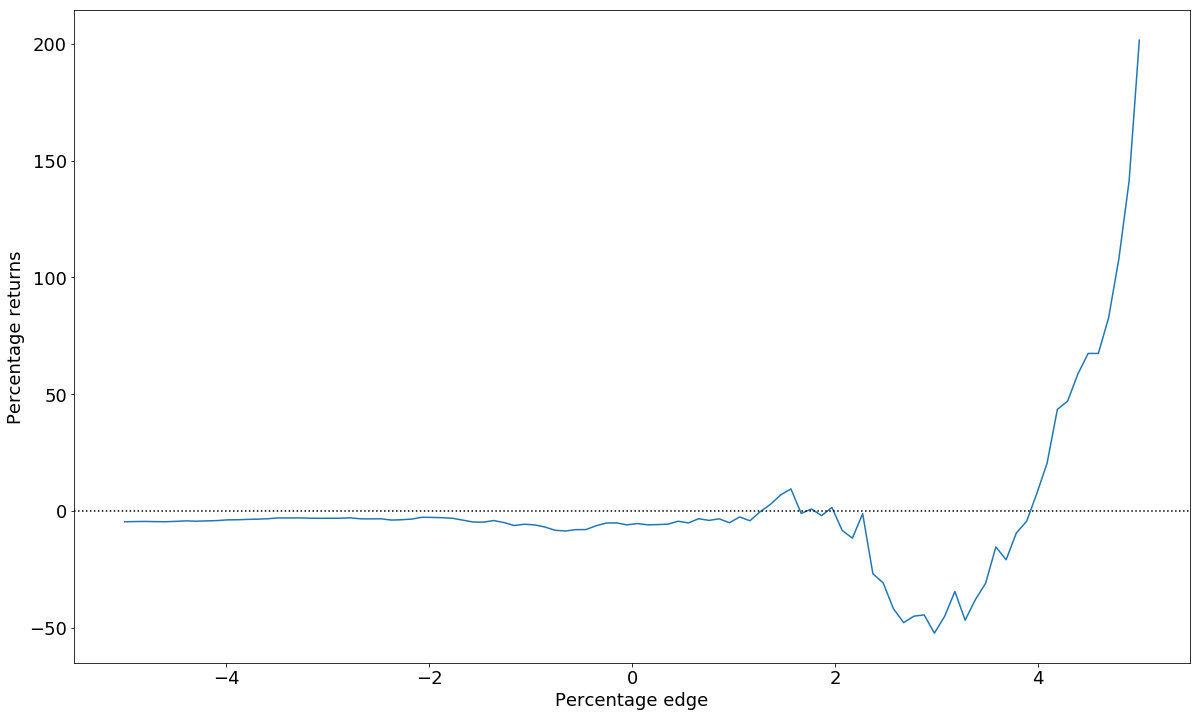

In [90]:
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(t, return_strategy)
ax.axhline(y=0, color='k', ls=':')
plt.xlabel('Percentage edge', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Percentage returns', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [143]:
merged[merged.prob_diff > 1.5].bet_return.sum()

Decimal('199.3')

In [91]:
merged.pct_back_difference.describe()

count    9056.000000
mean        0.277387
std         1.389260
min        -0.976330
25%        -0.221201
50%        -0.015358
75%         0.409582
max        70.649738
Name: pct_back_difference, dtype: float64

In [92]:
t = np.linspace(-1, 1, 100)
return_strategy = [100.*float(other_pct_returns(l, merged)) for l in t]

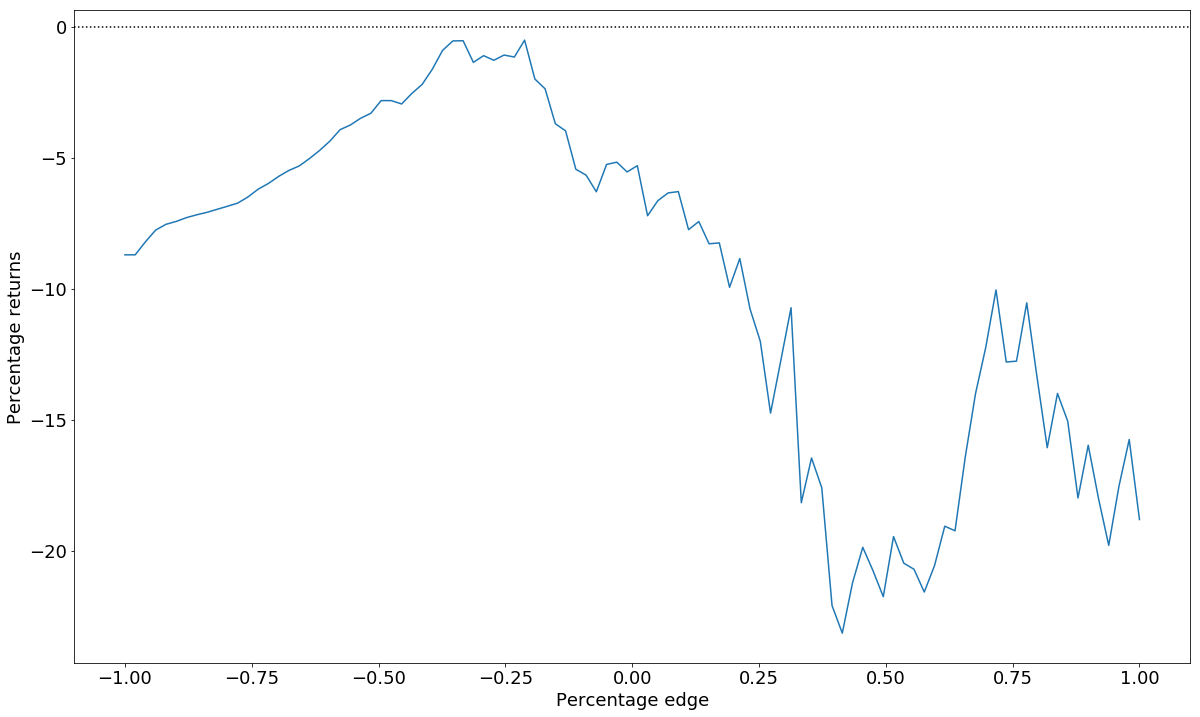

In [93]:
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(t, return_strategy)
ax.axhline(y=0, color='k', ls=':')
plt.xlabel('Percentage edge', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Percentage returns', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [109]:
merged.loc[:, 'lay_prob_diff'] = merged.apply(lambda x: float(x.lay_pct_chance) - x.back_prob, axis=1)
merged.sort_values(by='lay_prob_diff').head()

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff,bet_return,pct_back_difference,lay_prob_diff,lay_return
839,Tottenham v Barcelona,2 - 4,Any Other Away Win,Any Other Home Win,30.0,30,68.09,3.3333333333333333,29.0,27,...,1.172790,1.478477,2.740584,0.779170,16.969568,13.265864,-1,3.581783,-13.636234,1
74,Burnley U23 v Crewe U23,3 - 2,3 - 2,1 - 1,0.0,650,2,0.15384615384615384615,0.0,6.2,...,1.045378,1.485576,1.582174,1.107479,10.154465,-5.974567,-1,-0.370423,-10.000619,1
3744,Leyton Orient v Hartlepool,0 - 0,0 - 0,1 - 1,24.0,140,62.44,0.71428571428571428571,30.0,50,...,1.205698,1.390246,1.354613,1.254808,10.353243,8.353243,-1,4.176621,-9.638957,1
7839,Chesterfield v Wrexham,1 - 1,1 - 1,1 - 1,0.0,7.2,39.25,13.8888888888888889,0.0,6.8,...,1.016207,0.859640,0.616626,1.167124,23.158564,8.452681,6.8,0.574782,-9.269675,-7.2
8454,Millwall U23 v Colchester U23,2 - 3,2 - 3,1 - 1,0.0,200,3.92,0.50000000000000000000,0.0,8.6,...,0.977884,1.688381,1.784971,0.780676,8.889736,-2.738171,-1,-0.235483,-8.389736,1


In [110]:
merged.sort_values(by='lay_prob_diff', ascending=False).head()

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff,bet_return,pct_back_difference,lay_prob_diff,lay_return
96,Hendon v Lancing FC,1 - 1,1 - 1,0 - 0,1.03,1.03,3.03,97.0873786407766990,1.03,24,...,1.182145,1.359675,1.722344,1.187936,6.058738,1.892071,-1,0.454097,91.028641,1
10,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,2 - 0,1.13,1.08,3,92.5925925925925926,1.13,1.02,...,1.610078,1.327148,1.550304,1.349926,7.086808,-90.952407,1.02,-0.927715,85.505784,-1.08
4184,Nottm Forest U23 v Birmingham U23,0 - 1,0 - 1,0 - 1,1.11,1.09,3.07,91.7431192660550459,1.11,1.03,...,1.303134,1.178748,1.278722,1.229560,6.554195,-90.533183,1.03,-0.932492,85.188924,-1.09
3742,Leyton Orient v Hartlepool,0 - 0,0 - 0,0 - 0,1.26,1.11,41.81,90.0900900900900901,1.26,1.02,...,1.205698,1.390246,1.354613,1.254808,6.252326,-91.786890,1.02,-0.936226,83.837764,-1.11
1026,Crusaders v Cliftonville,2 - 2,2 - 2,2 - 2,1.2,1.2,5.94,83.3333333333333333,1.2,1.02,...,1.418916,1.183364,1.643300,1.321230,6.318900,-91.720316,1.02,-0.935547,77.014433,-1.2


In [111]:
def calculate_return_lay(row, stake=1):
    score_name = row.modified_score_name
    score_name_guess = row.score_name_y
    if score_name == score_name_guess:
        return -stake * row.lay_odds
    else:
        return stake

In [112]:
merged.loc[:, 'lay_return'] = merged.apply(lambda x: calculate_return_lay(x), axis=1)
merged.sort_values(by='lay_return', ascending=False).head(10)

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff,bet_return,pct_back_difference,lay_prob_diff,lay_return
0,Leeds U23 v Nottm Forest U23,2 - 0,2 - 0,0 - 0,0.0,65,0.76,1.5384615384615385,12.0,12.5,...,1.610078,1.327148,1.550304,1.349926,6.241082,-1.758918,-1,-0.219865,-4.702621,1
6102,MK Dons v Notts Co,2 - 1,2 - 1,1 - 1,9.8,10,89.96,10.0000000000000000,9.8,9.4,...,1.178821,1.622874,1.422015,0.956539,9.274399,-1.363899,-1,-0.128207,0.725601,1
6096,Oldham v Cheltenham,2 - 0,2 - 0,1 - 3,0.0,75,70.45,1.3333333333333333,0.0,60,...,1.159660,1.587526,1.353769,1.499372,4.477590,2.810923,-1,1.686554,-3.144257,1
6097,Oldham v Cheltenham,2 - 0,2 - 0,0 - 3,0.0,120,10.78,0.83333333333333333333,0.0,95,...,1.159660,1.587526,1.353769,1.499372,4.317289,3.264658,-1,3.101425,-3.483956,1
6098,Oldham v Cheltenham,2 - 0,2 - 0,Any Other Home Win,15.5,15.5,15.04,6.4516129032258065,15.5,14,...,1.159660,1.587526,1.353769,1.499372,2.555966,-4.586891,-1,-0.642165,3.895647,1
6099,Oldham v Cheltenham,2 - 0,2 - 0,Any Other Away Win,0.0,690,80.22,0.14492753623188405797,0.0,65,...,1.159660,1.587526,1.353769,1.499372,3.236556,1.698094,-1,1.103761,-3.091628,1
6100,MK Dons v Notts Co,2 - 1,2 - 1,0 - 0,19.0,19,42.37,5.2631578947368421,17.5,17.5,...,1.178821,1.622874,1.422015,0.956539,6.140746,0.426460,-1,0.074631,-0.877588,1
6101,MK Dons v Notts Co,2 - 1,2 - 1,1 - 0,9.6,9.8,19,10.2040816326530612,9.6,9.4,...,1.178821,1.622874,1.422015,0.956539,10.721976,0.083678,-1,0.007866,-0.517894,1
6103,MK Dons v Notts Co,2 - 1,2 - 1,0 - 1,0.0,24,28.08,4.1666666666666667,0.0,21,...,1.178821,1.622874,1.422015,0.956539,6.924663,2.162759,-1,0.454179,-2.757997,1
6076,Wrexham v Harrogate Town,2 - 0,2 - 0,3 - 3,0.0,180,2.62,0.55555555555555555556,0.0,75,...,1.435068,1.176991,1.161104,0.927511,2.468717,1.135383,-1,0.851537,-1.913161,1


In [113]:
merged.sort_values(by='lay_return', ascending=True).head(10)

,event_name,score_name_x,modified_score_name,score_name_y,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,...,away_attack_elo,away_defence_elo,expected_home_goals,expected_away_goals,back_prob,prob_diff,bet_return,pct_back_difference,lay_prob_diff,lay_return
8853,Concord Rangers v Chelmsford,3 - 0,3 - 0,3 - 0,0.0,140,8.58,0.71428571428571428571,0.0,60,...,1.255764,1.039675,1.054169,0.953810,3.757627,2.090960,60,1.254576,-3.043341,-140
7980,Hartlepool v Sutton Utd,2 - 3,2 - 3,2 - 3,0.0,130,0.39,0.76923076923076923077,0.0,32,...,1.224036,1.104546,0.832765,1.115745,3.248844,0.123844,32,0.039630,-2.479613,-130
2628,Coalville Town v St Neots Town,3 - 3,3 - 3,3 - 3,0.0,120,3.65,0.83333333333333333333,0.0,55,...,0.943471,1.360492,1.356510,0.907285,2.520702,0.702520,55,0.386386,-1.687369,-120
439,Newport County v Macclesfield,3 - 3,3 - 3,3 - 3,100.0,120,42.32,0.83333333333333333333,100.0,100,...,1.088558,1.401806,1.423954,1.007661,2.785695,1.785695,100,1.785695,-1.952362,-120
4424,Fulham U23 v West Brom U23,0 - 3,0 - 3,0 - 3,0.0,120,3.03,0.83333333333333333333,0.0,55,...,0.880102,1.693672,1.830780,0.783916,3.827367,2.009186,55,1.105052,-2.994034,-120
1900,Queen of South v Alloa,3 - 3,3 - 3,3 - 3,0.0,110,3.52,0.90909090909090909091,0.0,75,...,1.242855,1.208485,1.086078,1.403788,3.367659,2.034325,75,1.525744,-2.458568,-110
1290,Swansea v Ipswich,2 - 3,2 - 3,2 - 3,95.0,110,36.07,0.90909090909090909091,95.0,95,...,1.038131,1.163579,1.084513,0.825017,2.680481,1.627849,95,1.546457,-1.771390,-110
533,Aston Villa v Preston,3 - 3,3 - 3,3 - 3,110.0,110,1.88,0.90909090909090909091,110.0,100,...,1.390803,1.358432,1.675252,1.359363,2.759967,1.759967,100,1.759967,-1.850876,-110
5841,Charlton U23 v Ipswich U23,2 - 2,2 - 2,2 - 2,0.0,90,3.82,1.1111111111111111,0.0,8.8,...,1.279599,1.264736,1.383846,0.958775,6.586616,-4.777021,8.8,-0.420378,-5.475505,-90
4659,Doncaster v Gillingham,3 - 3,3 - 3,3 - 3,90.0,85,2.5,1.1764705882352941,80.0,75,...,1.274330,1.262142,1.222122,1.076069,2.954868,1.621535,75,1.216151,-1.778397,-85


In [114]:
merged.bet_return.sum()

Decimal('-787.82')

In [115]:
merged.lay_return.sum()

Decimal('-1288.34')

In [116]:
merged[merged.lay_prob_diff > 2].lay_return.sum()

Decimal('187.56')

In [117]:
merged[merged.lay_prob_diff < -2].lay_return.sum()

Decimal('-996.7')

In [118]:
merged.lay_prob_diff.describe()

count    9056.000000
mean       -0.444153
std         3.609576
min       -13.636234
25%        -2.015765
50%        -0.964758
75%         0.616394
max        91.028641
Name: lay_prob_diff, dtype: float64

In [123]:
def lay_pct_returns(val, frame):
    return frame[frame.lay_prob_diff > val].lay_return.sum() / frame[frame.prob_diff > val].shape[0]

t = np.linspace(-2, 2, 200)
return_strategy = [100.*float(pct_returns(l, merged)) for l in t]
return_strategy[0]

-2.7293777134587556

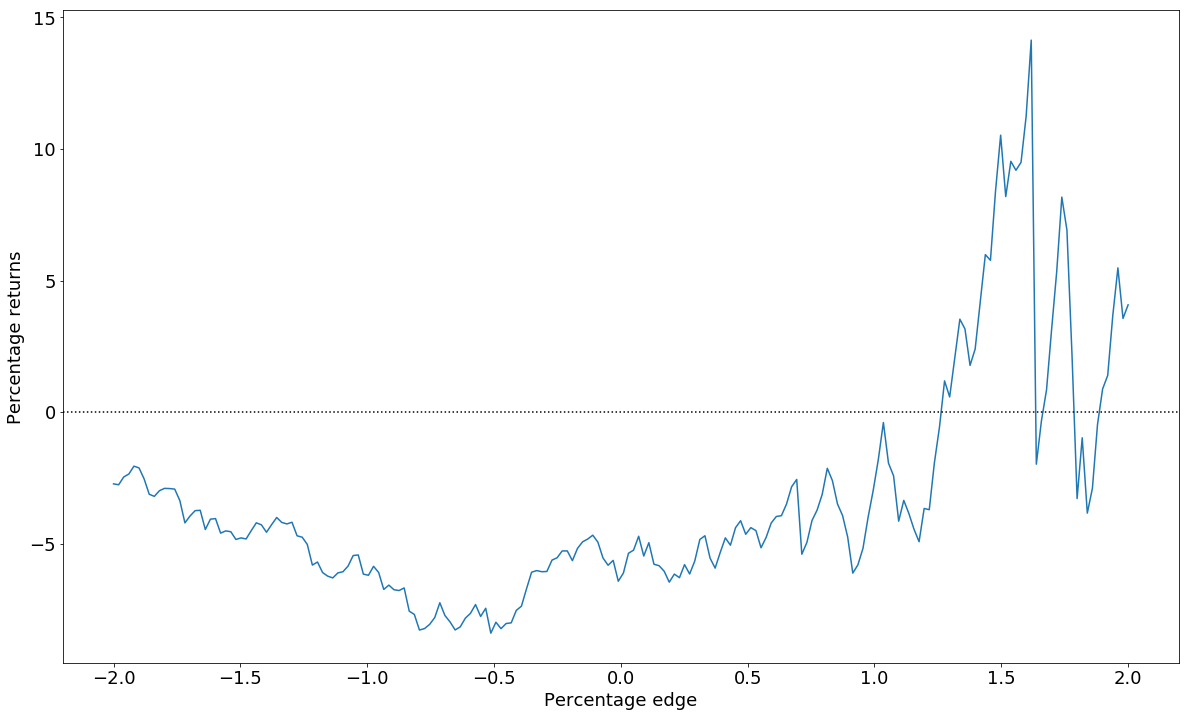

In [124]:
fig, ax = plt.subplots(figsize=(20,12))
plt.plot(t, return_strategy)
ax.axhline(y=0, color='k', ls=':')
plt.xlabel('Percentage edge', fontsize=18)
plt.xticks(fontsize=18)
plt.ylabel('Percentage returns', fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [127]:
merged[merged.lay_prob_diff > 1.5].lay_return.sum()

Decimal('188.76')

In [129]:
merged[merged.lay_prob_diff > 1.5][['event_name', 'modified_score_name', 'score_name_y', 'back_odds', 'lay_odds', 'lay_vol', 'back_prob', 'lay_prob_diff', 'lay_return', 'bet_return']].sort_values(by='lay_prob_diff')



,event_name,modified_score_name,score_name_y,back_odds,lay_odds,lay_vol,back_prob,lay_prob_diff,lay_return,bet_return
5739,Huddersfield v Liverpool,0 - 1,0 - 3,9.2,9.4,169.03,9.137158,1.501140,1,-1
6231,Blackpool v Scunthorpe,1 - 0,2 - 0,10.5,11.5,117.16,7.192492,1.503160,1,-1
505,Brentford v Birmingham,1 - 1,2 - 0,9.2,9.6,18.07,8.913366,1.503301,1,-1
7320,Cheltenham v Stevenage,0 - 2,1 - 0,10,10.5,131.89,8.019755,1.504054,1,-1
4179,Connahs Quay v Coleraine,2 - 0,Any Other Home Win,13.5,23,5.21,2.843366,1.504460,1,-1
5196,Reading v Millwall,3 - 1,1 - 0,10.5,11.5,434.78,7.189123,1.506529,1,-1
5142,Cardiff v Fulham,Any Other Home Win,1 - 0,11,12,346.52,6.823998,1.509335,1,-1
1243,West Brom v Reading,Any Other Home Win,1 - 1,9.6,10,77.93,8.489761,1.510239,1,-1
6140,Forest Green v Tranmere,3 - 1,2 - 0,12.5,14,31.38,5.632371,1.510486,1,-1
2732,Redditch Utd v Halesowen Town,2 - 1,0 - 2,13,15.5,7.74,4.939068,1.512545,1,-1


In [131]:
odds_df.head()

,event_name,score_name,lay_ltp,lay_odds,lay_vol,lay_pct_chance,back_ltp,back_odds,back_vol,back_pct_chance
0,18746827,0 - 0,0.0,60,9.66,1.6666666666666667,0.0,30,6.9,3.3333333333333333
1,18746827,1 - 0,0.0,24,21.11,4.1666666666666667,0.0,13.5,16,7.4074074074074074
2,18746827,1 - 1,0.0,17,26.53,5.8823529411764706,0.0,12.5,4,8.0000000000000000
3,18746827,0 - 1,0.0,46,1.57,2.1739130434782609,0.0,27,7.69,3.7037037037037037
4,18746827,2 - 0,0.0,18,10.2,5.5555555555555556,0.0,12.5,21.38,8.0000000000000000
